In [1]:
# =============
# CARGA DE LIBRERIAS

import glob
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# =============
# DEFINICION DEL MODELO

def gradients(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
alpha = 1            # coeficiente de difusion termica
L = 10               # dominio [0,10] en x
T_MAX = 1            # tiempo maximo
N_STEPS = 2500       # numero de iteraciones de entrenamiento
N_COLLOC = 25000     # numero de muestras para la PDE
N_IC = 25000         # numero de muestras para la condicion inicial
N_BC = N_IC          # numero de muestras para la condicion de frontera

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class HEAT(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = HEAT([100,100,100,100,100,100,100,100]).to(device)                            
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [3]:
# =============
# BUCLE DE ENTRENAMIENTO

# Parametros
EXTRA_EPOCHS = 0
lambda_ic    = 10
lambda_bc    = 10
model_path   = 'models/heat2D/heat2D'
os.makedirs(model_path, exist_ok=True)

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        import math
        u = torch.rand(N_COLLOC, 1, device=device)
        v = torch.rand(N_COLLOC, 1, device=device)

        # Muestreo uniforme
        mask = (u + v) > 1.0
        u[mask] = 1.0 - u[mask]
        v[mask] = 1.0 - v[mask]

        V1 = torch.tensor([L, 0.0], device=device)
        V2 = torch.tensor([L / 2.0, (math.sqrt(3) / 2.0) * L], device=device)

        coords = u * V1 + v * V2

        # Separamos en x y y
        x = coords[:, 0:1]    # [N_COLLOC, 1]
        y = coords[:, 1:1+1]  # [N_COLLOC, 1]

        t = torch.rand(N_COLLOC, 1, device=device) * T_MAX    # [N_COLLOC, 1]
        X = torch.cat([x, y, t], dim=1).requires_grad_(True)  # [N_COLLOC, 3]

        u_pred = mlp(X)[:, 0].unsqueeze(1)  # [N_COLLOC, 1]
        grads = gradients(u_pred, X)
        u_x = grads[:, 0].unsqueeze(1)      # [N_COLLOC, 1]
        u_y = grads[:, 1].unsqueeze(1)      # [N_COLLOC, 1]
        u_t = grads[:, 2].unsqueeze(1)      # [N_COLLOC, 1]

        grads_x = gradients(u_x, X)
        u_xx = grads_x[:, 0].unsqueeze(1)   # [N_COLLOC, 1]

        grads_y = gradients(u_y, X)
        u_yy = grads_y[:, 1].unsqueeze(1)   # [N_COLLOC, 1]

        loss_pde = mse(u_t, alpha * (u_xx + u_yy))


        u0 = torch.rand(N_IC, 1, device=device)
        v0 = torch.rand(N_IC, 1, device=device)
        mask0 = (u0 + v0) > 1.0
        u0[mask0] = 1.0 - u0[mask0]
        v0[mask0] = 1.0 - v0[mask0]
        coords0 = u0 * V1 + v0 * V2     # [N_IC, 2]
        x0 = coords0[:, 0:1]            # [N_IC, 1]
        y0 = coords0[:, 1:1+1]          # [N_IC, 1]
        t0 = torch.zeros(N_IC, 1, device=device)  # Todos en t = 0

        xc = L / 2
        yc = L / 3

        u0_true = torch.exp(-(((x0 - xc) ** 2 + (y0 - yc) ** 2)))  # [N_IC, 1]

        X0 = torch.cat([x0, y0, t0], dim=1).requires_grad_(True)   # [N_IC, 3]
        u0_hat = mlp(X0)[:, 0].unsqueeze(1)                        # [N_IC, 1]

        loss_ic = lambda_ic * mse(u0_hat, u0_true)


        # Seleccionamos aleatoriamente para cada punto que arista corresponde
        edges = torch.randint(0, 3, (N_BC,), device=device)  # 0, 1 o 2

        # Generamos un parametro s
        s_bc = torch.rand(N_BC, 1, device=device)

        # Inicializamos tensores para las coordenadas de frontera
        x_b = torch.zeros(N_BC, 1, device=device)
        y_b = torch.zeros(N_BC, 1, device=device)

        mask_e0 = (edges == 0)
        x_b[mask_e0] = L * s_bc[mask_e0]
        y_b[mask_e0] = 0.0

        mask_e1 = (edges == 1)
        x_b[mask_e1] = L - s_bc[mask_e1] * (L / 2.0)
        y_b[mask_e1] = s_bc[mask_e1] * (math.sqrt(3) / 2.0) * L

        mask_e2 = (edges == 2)
        x_b[mask_e2] = (L / 2.0) * (1.0 - s_bc[mask_e2])
        y_b[mask_e2] = (L * (math.sqrt(3) / 2.0)) * (1.0 - s_bc[mask_e2])

        t_b = torch.rand(N_BC, 1, device=device) * T_MAX  # [N_BC, 1]
        Xb = torch.cat([x_b, y_b, t_b], dim=1)            # [N_BC, 3]
        u_b_pred = mlp(Xb)[:, 0].unsqueeze(1)             # [N_BC, 1]
        loss_bc = lambda_bc * mse(u_b_pred, torch.zeros_like(u_b_pred))

        optimizer.zero_grad()
        loss = loss_pde + loss_ic + loss_bc
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss = loss.item()

        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "ic":  f"{loss_ic.item():.2e}",
            "bc":  f"{loss_bc.item():.2e}"
        })

    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e} — lr: {optimizer.param_groups[0]['lr']}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_ic': loss_ic/lambda_ic,
        'loss_bc': loss_bc/lambda_bc
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

Cargado checkpoint de la época 10.
Entrenamiento completado.


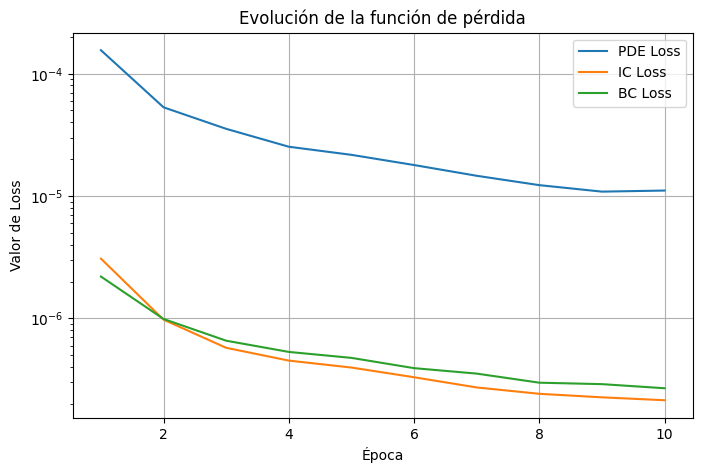

In [4]:
# =============
# REPRESENTACION DE LA EVOLUCION DEL ERROR

# Definir ruta y buscar archivos de checkpoint
model_path   = 'models/heat2D/heat2D'
checkpoint_pattern = f"{model_path}_*.pth"
checkpoint_files = sorted(glob.glob(checkpoint_pattern))

# Preparar listas para almacenar datos
epochs    = []
loss_pde  = []
loss_ic   = []
loss_bc   = []

# Recorrer cada archivo y extraer la información
device = 'cpu'
for ckpt_file in checkpoint_files:
    ckpt = torch.load(ckpt_file, map_location=device)
    epoch_num = ckpt['epoch'] - 1
    epochs.append(epoch_num)
    loss_pde.append(ckpt['loss_pde'].item())
    loss_ic.append(ckpt['loss_ic'].item())
    loss_bc.append(ckpt['loss_bc'].item())

# Graficar las curvas de perdida
plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.plot(epochs, loss_pde, label='PDE Loss')
plt.plot(epochs, loss_ic,  label='IC Loss')
plt.plot(epochs, loss_bc,  label='BC Loss')
plt.xlabel('Época')
plt.ylabel('Valor de Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()
plt.grid(True)
plt.show()

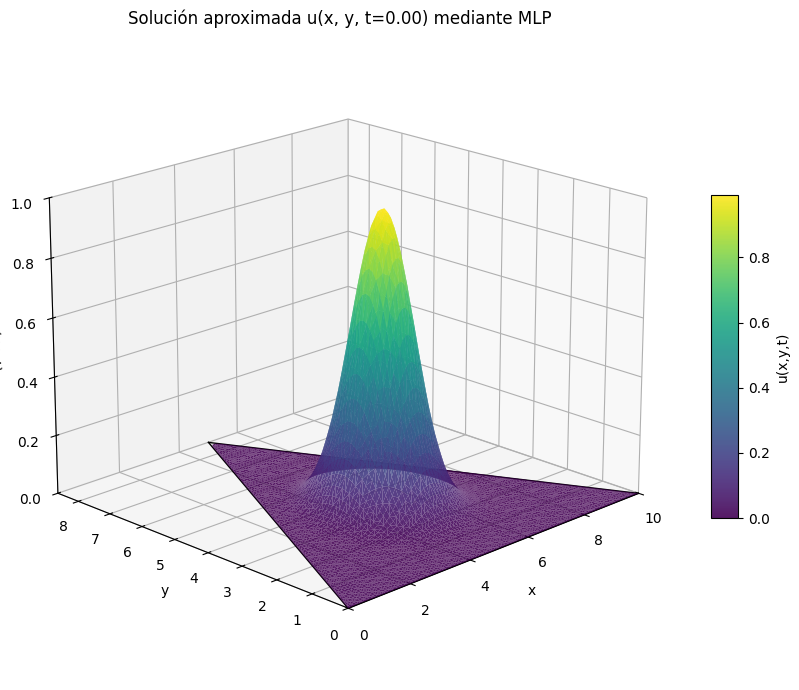

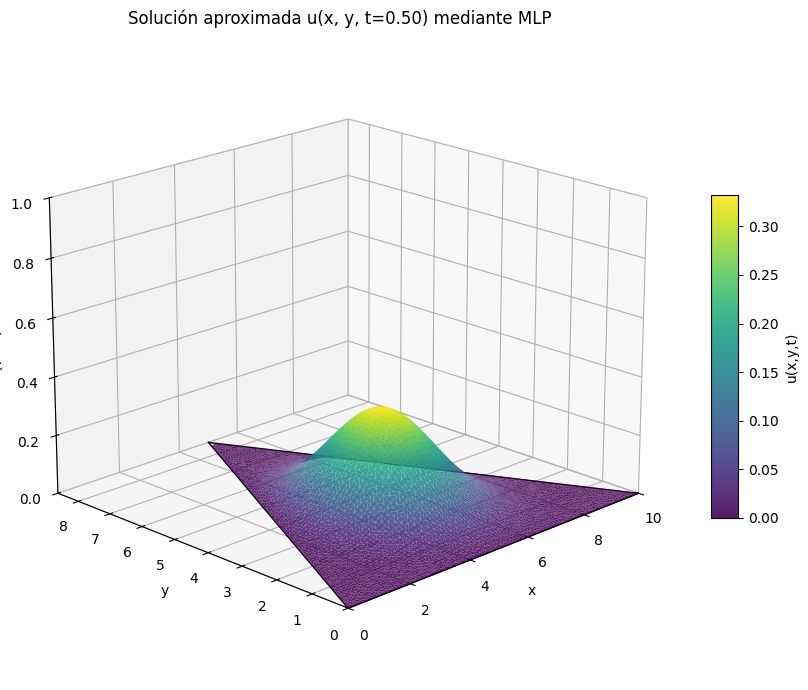

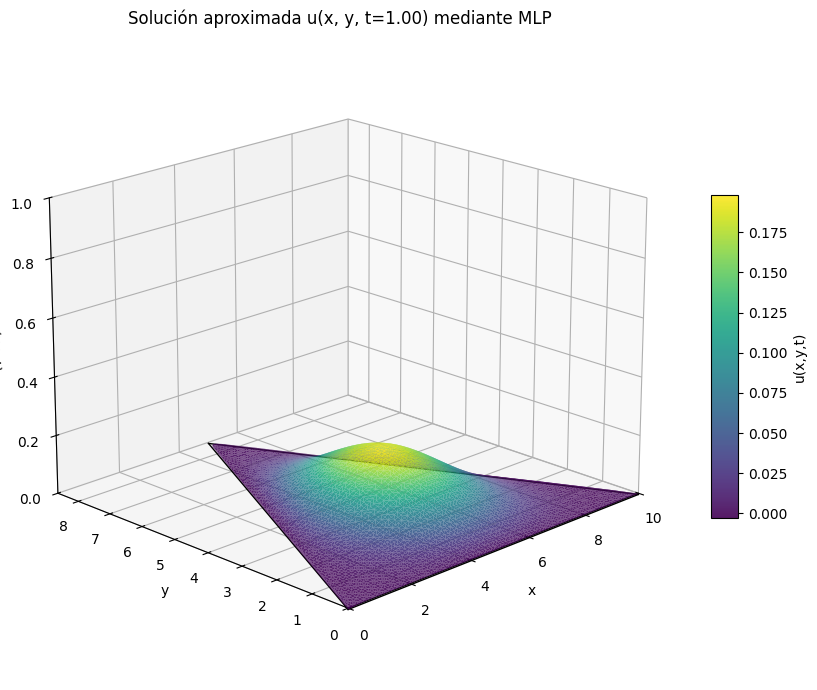

In [5]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

# Parametros
N = 100
L = L
T_MAX = T_MAX
mlp.eval()
mlp.cpu()
tvec = [0.0, T_MAX/2, T_MAX]

for t_plot in tvec:
    x_lin = np.linspace(0.0, L, N)
    y_lin = np.linspace(0.0, L, N)
    Xg, Yg = np.meshgrid(x_lin, y_lin)

    # Filtro del triangulo equilatero
    h = (np.sqrt(3) / 2.0) * L
    mask_interior = (
        (Yg >= 0.0) &
        (Yg <= np.sqrt(3) * Xg) &
        (Yg <= -np.sqrt(3) * (Xg - L))
    )
    X_pts = Xg[mask_interior]
    Y_pts = Yg[mask_interior]
    T_pts = np.full_like(X_pts, t_plot)

    # Preparacion del tensor de entrada y prediccion
    XYT = np.stack([X_pts, Y_pts, T_pts], axis=1)
    inp = torch.from_numpy(XYT).float()
    with torch.no_grad():
        u_pred_flat = mlp(inp).squeeze().cpu().numpy()

    # Graficacion 3D con eje z fijo
    fig = plt.figure(figsize=(10, 7))
    ax  = fig.add_subplot(111, projection='3d')

    trisurf = ax.plot_trisurf(
        X_pts, Y_pts, u_pred_flat,
        cmap='viridis', linewidth=0.0, antialiased=True, alpha=0.9
    )

    ax.set_title(f'Solución aproximada u(x, y, t={t_plot:.2f}) mediante MLP')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, L)
    ax.set_ylim(0, math.sqrt(3/4)*L)
    ax.set_zlim(0, 1)
    ax.view_init(elev=19, azim=225)  # angulo de vista
    ax.set_zlabel('u(x,y,t)')

    # Contorno del triangulo
    min_u = np.min(u_pred_flat)
    ax.plot([0, L], [0, 0], [min_u, min_u], color='k', linewidth=1)
    ax.plot([L, L/2], [0, h], [min_u, min_u], color='k', linewidth=1)
    ax.plot([L/2, 0], [h, 0], [min_u, min_u], color='k', linewidth=1)

    # Barra de color
    fig.colorbar(trisurf, ax=ax, shrink=0.5, aspect=12, label='u(x,y,t)')

    plt.tight_layout()
    plt.show()

MSE en t = 0.00 → 2.225078e-07


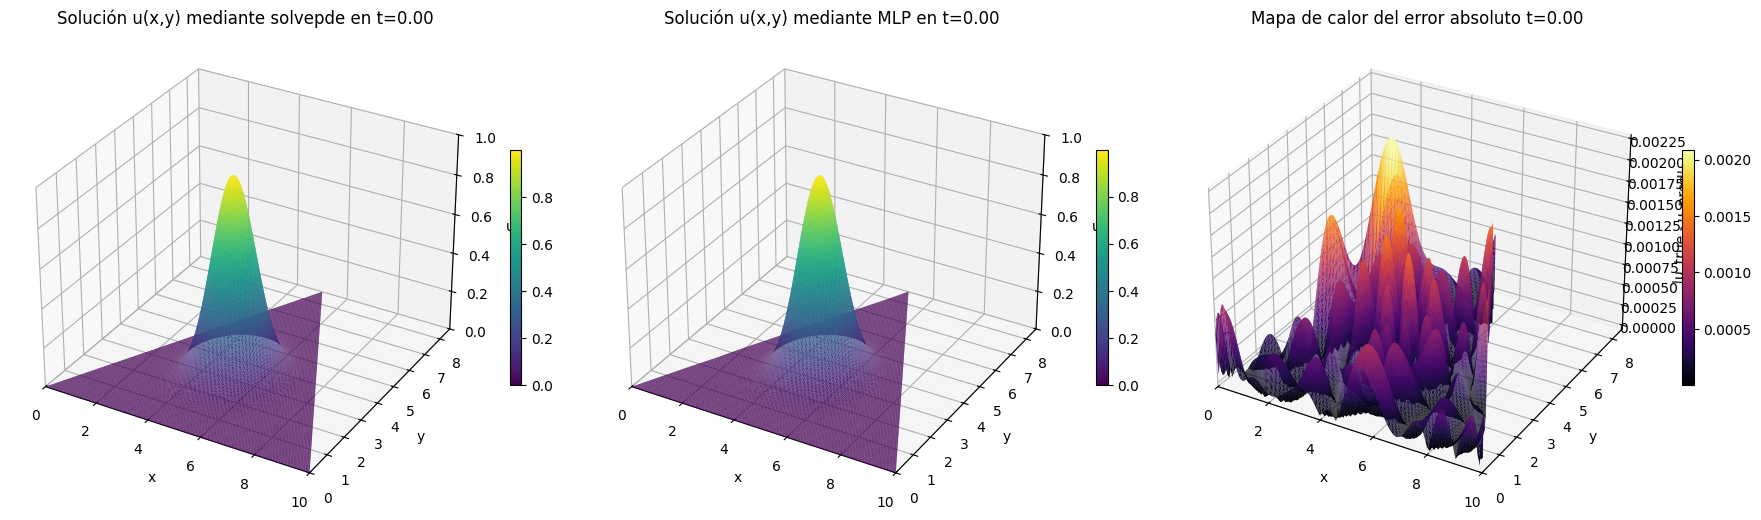

MSE en t = 0.50 → 4.731054e-08


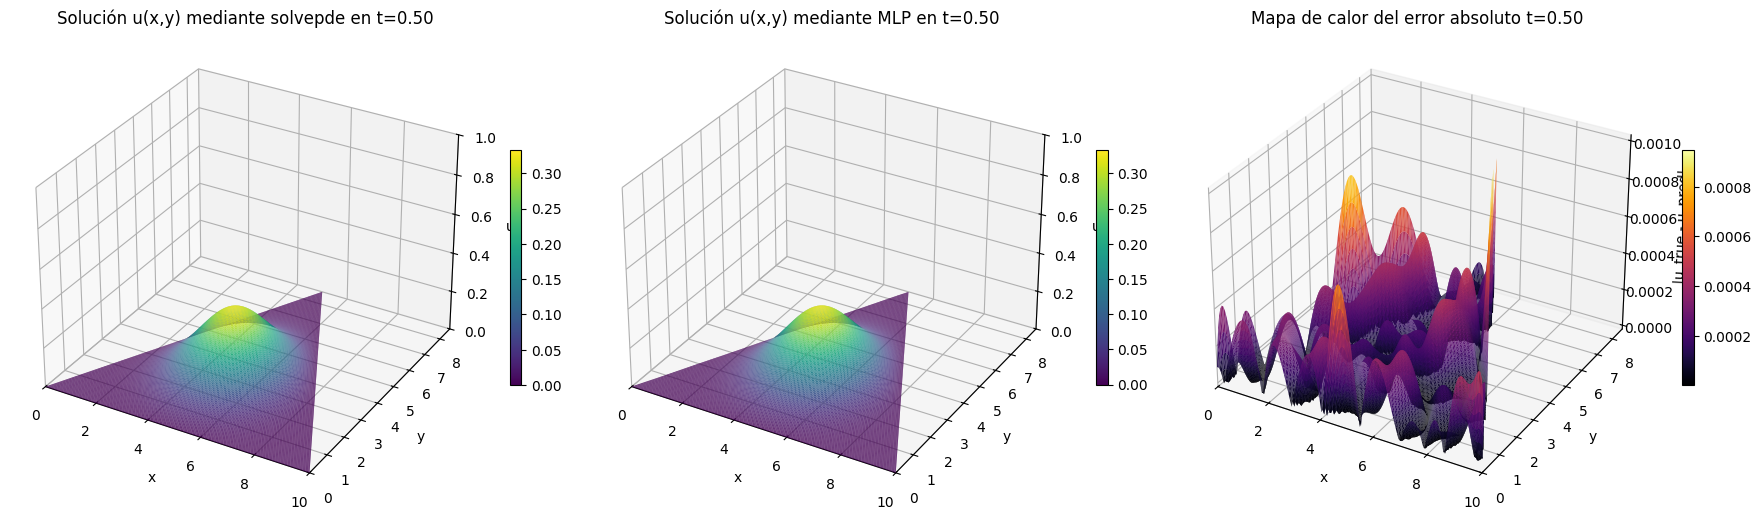

MSE en t = 1.00 → 9.997611e-08


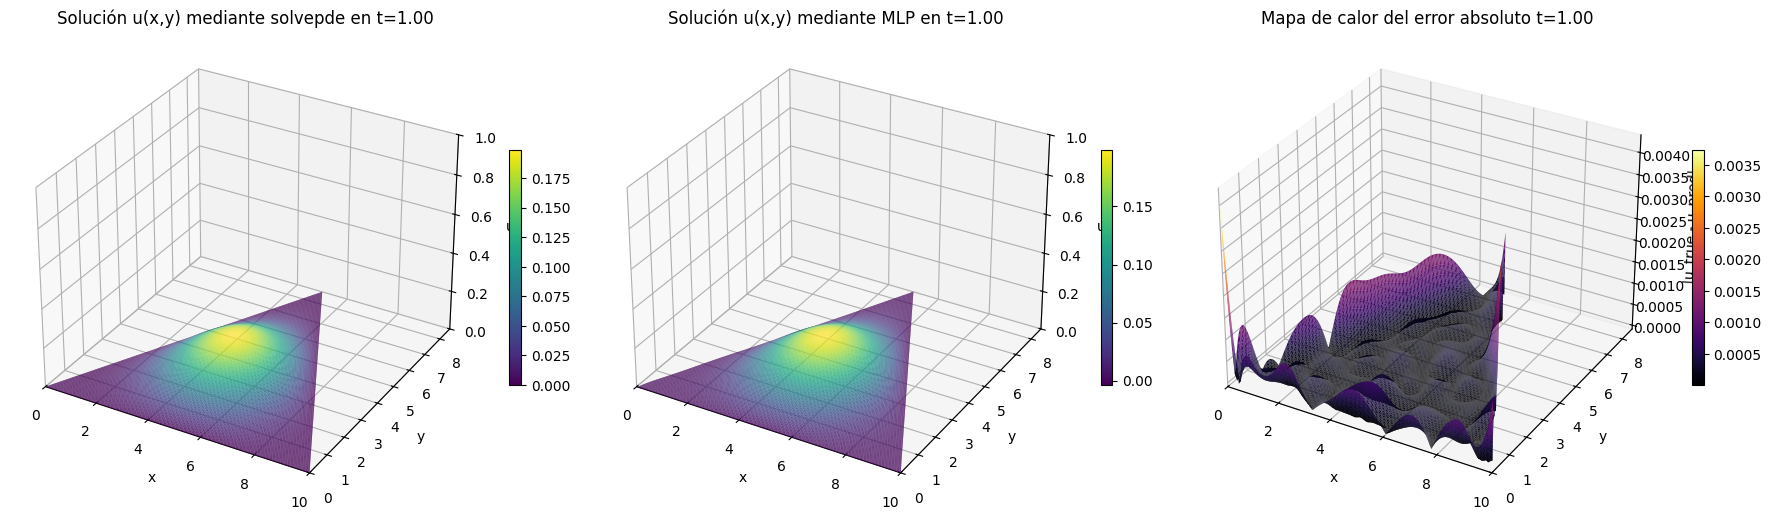

In [6]:
# =============
# COMPARACION CON SOLVEPDE

import numpy as np
import torch
import math
from sklearn.metrics import mean_squared_error

# Carga de datos exportados desde MATLAB
data = np.loadtxt('heat_2D_results.csv', delimiter=',') # columnas: x, y, u(t0), u(t1), ..., u(tN)

# Separa coordenadas (N×2) y valores de la aproximacion (N×Nt)
coords = data[:, 0:2]
fem_values = data[:, 2:]

# Parametros de tiempo
T_MAX = 1.0
dt = 0.01
tlist = np.arange(0.0, T_MAX + dt/2, dt)
tvec = [0.0, T_MAX/2, T_MAX]

mlp.eval()
mse_results = {}
for t in tvec:
    # Indice de tiempo mas cercano
    idx = np.argmin(np.abs(tlist - t))
    
    # Preparar entrada para la MLP: (N,3) con (x, y, t)
    N = coords.shape[0]
    T_column = np.full((N, 1), t)
    inp = np.hstack([coords, T_column])
    inp_tensor = torch.from_numpy(inp).float()
    
    # Predecir con la MLP
    with torch.no_grad():
        u_pred = mlp(inp_tensor).squeeze().cpu().numpy()
    
    # Obtener la solucion solvepde en ese instante
    u_true = fem_values[:, idx]
    
    # Calcular MSE
    mse = mean_squared_error(u_true, u_pred)
    print(f"MSE en t = {t:.2f} → {mse:.6e}")
    
    u_err = np.abs(u_true - u_pred)
    fig = plt.figure(figsize=(18, 5))
    
    # Solucion solvepde
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    surf1 = ax1.plot_trisurf(coords[:,0], coords[:,1], u_true,
                             cmap='viridis', linewidth=0, antialiased=True)
    ax1.set_title(f'Solución u(x,y) mediante solvepde en t={t:.2f}')
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
    ax1.set_xlim(0, L); ax1.set_ylim(0, math.sqrt(3/4)*L); ax1.set_zlim(0, 1)
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Prediccion MLP
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    surf2 = ax2.plot_trisurf(coords[:,0], coords[:,1], u_pred,
                             cmap='viridis', linewidth=0, antialiased=True)
    ax2.set_title(f'Solución u(x,y) mediante MLP en t={t:.2f}')
    ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
    ax2.set_xlim(0, L); ax2.set_ylim(0, math.sqrt(3/4)*L); ax2.set_zlim(0, 1)
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    # Error absoluto
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    surf3 = ax3.plot_trisurf(coords[:,0], coords[:,1], u_err,
                             cmap='inferno', linewidth=0, antialiased=True)
    ax3.set_title(f'Mapa de calor del error absoluto t={t:.2f}')
    ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('|u_true - u_pred|')
    ax3.set_xlim(0, L); ax3.set_ylim(0, math.sqrt(3/4)*L)
    fig.colorbar(surf3, ax=ax3, shrink=0.5)
    
    plt.tight_layout()
    plt.show()